## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


# Data Visualization

In [5]:
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

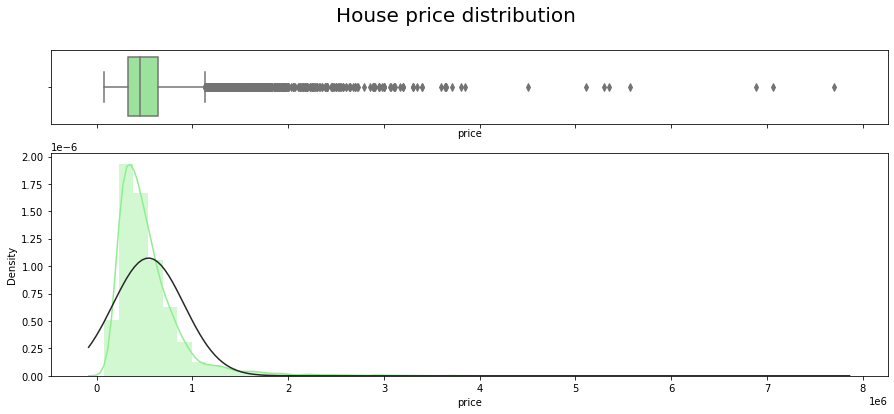

In [6]:
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 6), sharex=True, gridspec_kw = {"height_ratios": (.25, .75)})
f.suptitle("House price distribution", fontsize=20)

sns.boxplot(data['price'], ax=ax_box, color = 'lightgreen')
p = sns.distplot(data['price'], ax=ax_hist, fit = sp.stats.norm, color = 'lightgreen')

In [7]:
print("Skewness(왜도): ", data['price'].skew())
print("Kurtosis(첨도): ", data['price'].kurt())

Skewness(왜도):  4.290252396939529
Kurtosis(첨도):  40.15491919350329


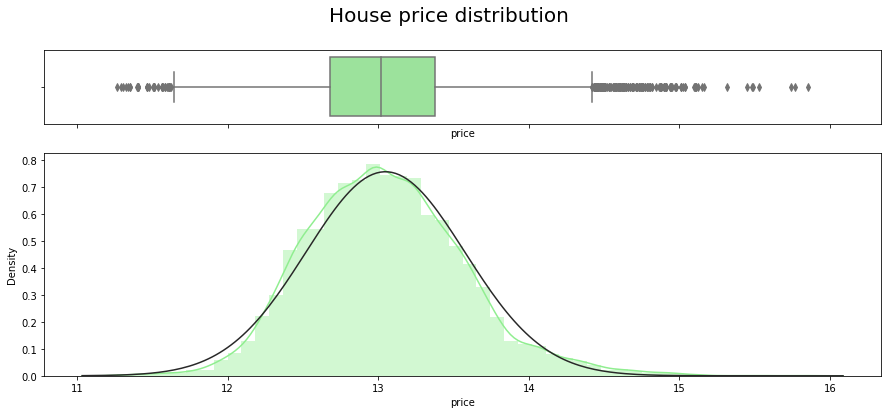

In [8]:
data['price'] = np.log1p(data['price'])

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 6), sharex=True, gridspec_kw = {"height_ratios": (.25, .75)})
f.suptitle("House price distribution", fontsize=20)

sns.boxplot(data['price'], ax=ax_box, color = 'lightgreen')
p = sns.distplot(data['price'], ax=ax_hist, fit = sp.stats.norm, color = 'lightgreen')

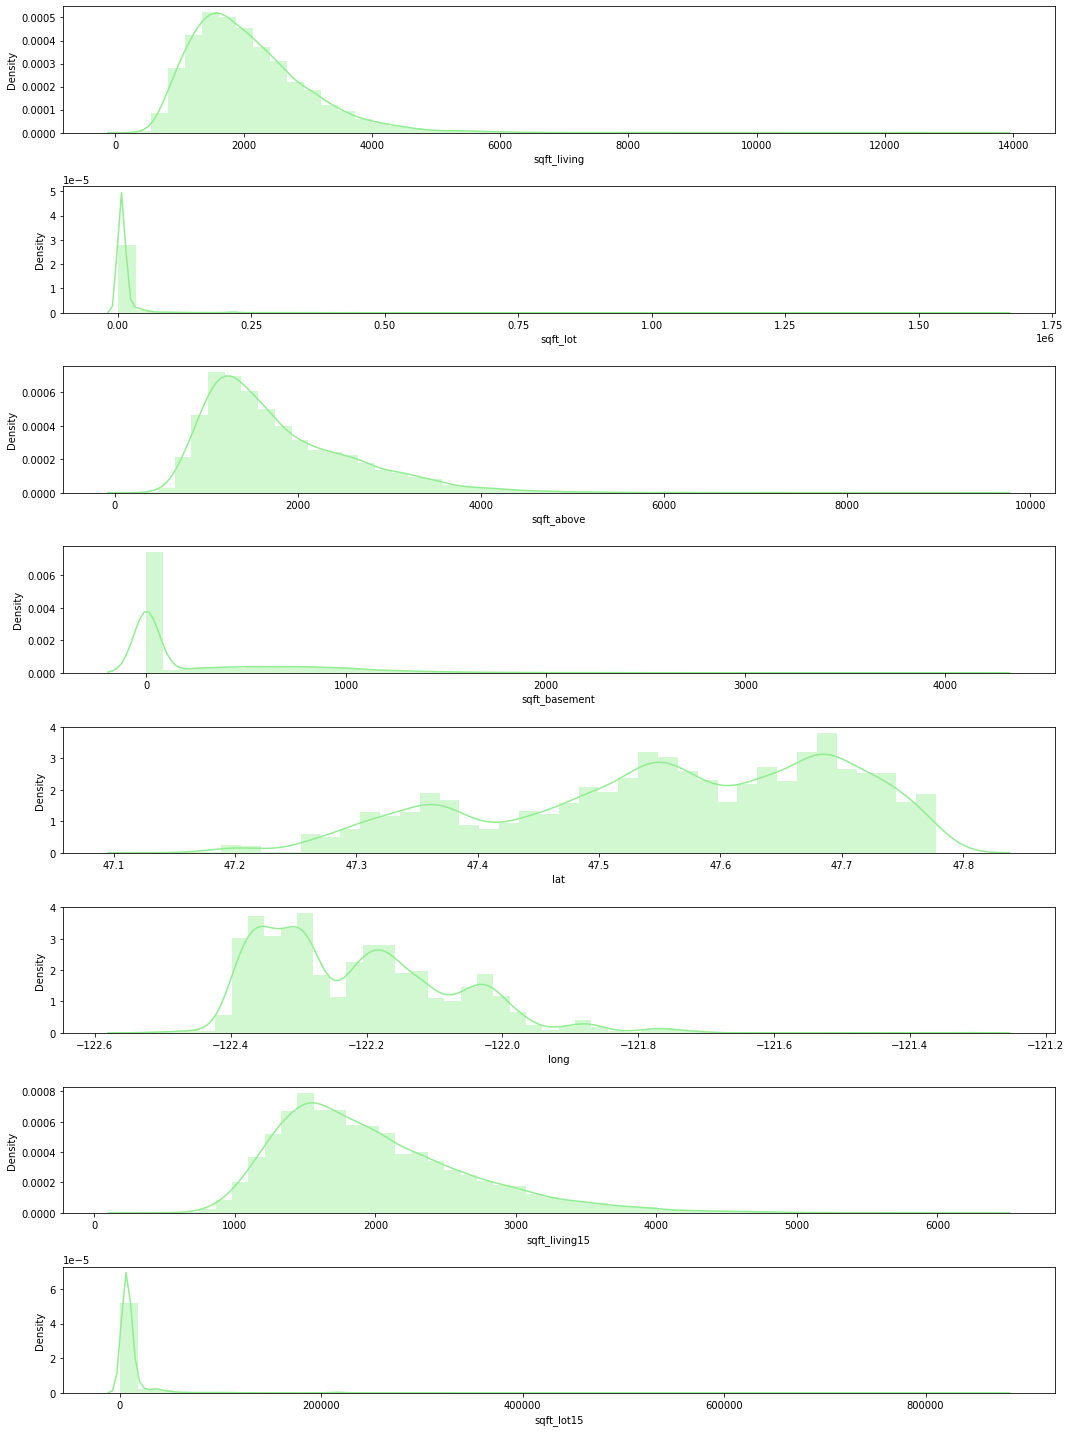

In [9]:
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
plt.figure(figsize=(15,20))
count = 1
for col in continuous:
    plt.subplot(len(continuous), 1, count)
    sns.distplot(data[col], color='lightgreen')
    count += 1
plt.tight_layout()

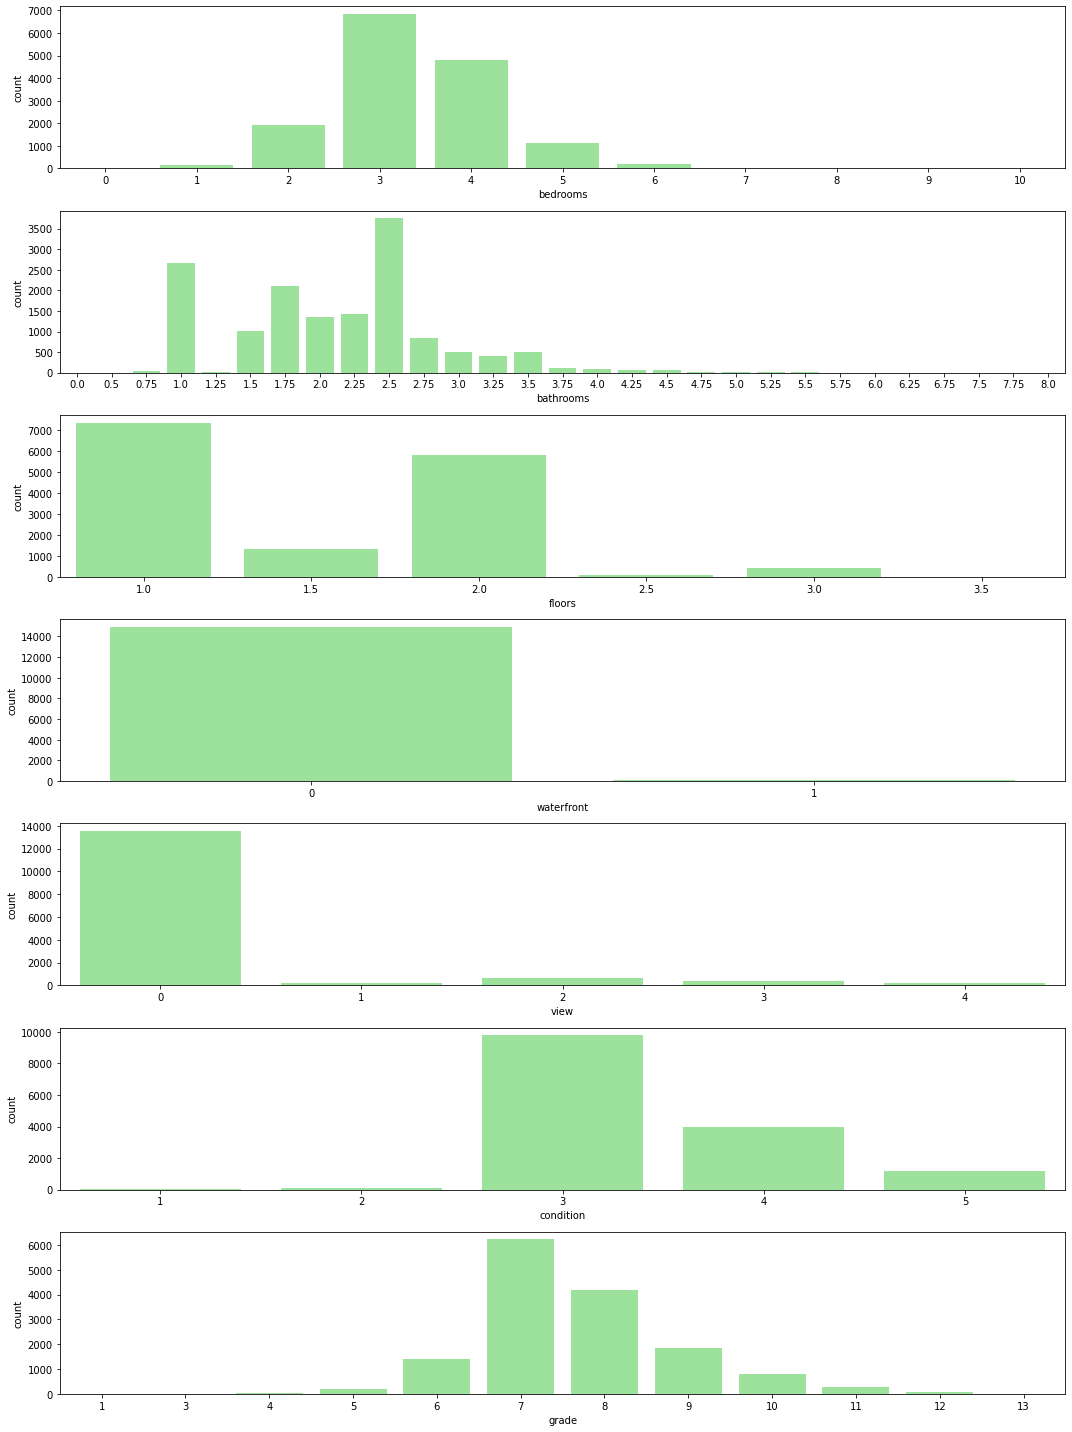

In [10]:
non_continuous = ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade']
plt.figure(figsize=(15,20))
count = 1
for col in non_continuous:
    plt.subplot(len(non_continuous), 1, count)
    sns.countplot(x=col,data=data, color='lightgreen')
    count += 1
plt.tight_layout()

# Data Preprocessing

## Checking Outliers

<AxesSubplot:xlabel='sqft_lot15'>

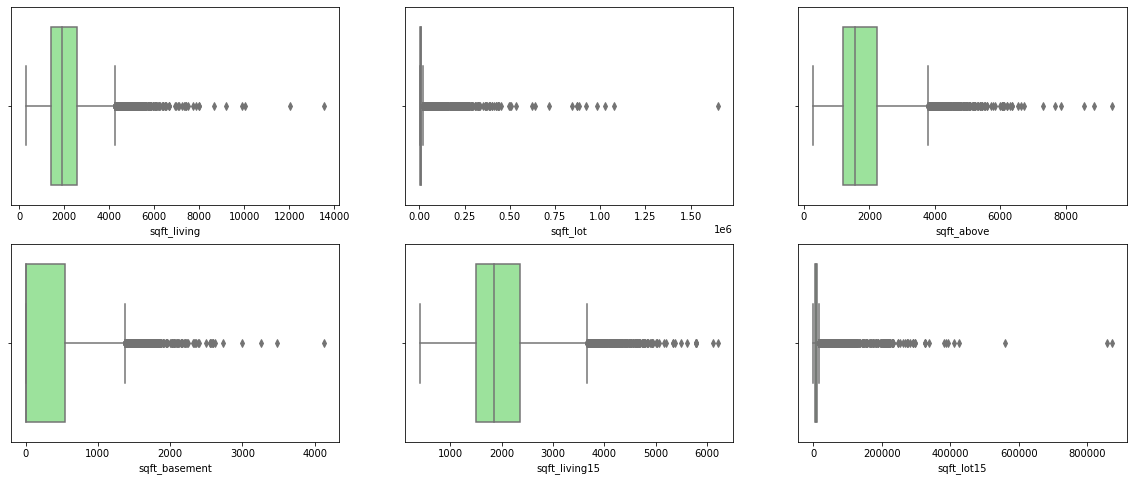

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(231)
sns.boxplot(x=data.sqft_living, color='lightgreen')

plt.subplot(232)
sns.boxplot(x=data.sqft_lot, color='lightgreen')

plt.subplot(233)
sns.boxplot(x=data.sqft_above, color='lightgreen')

plt.subplot(234)
sns.boxplot(x=data.sqft_basement, color='lightgreen')

plt.subplot(235)
sns.boxplot(x=data.sqft_living15, color='lightgreen')

plt.subplot(236)
sns.boxplot(x=data.sqft_lot15, color='lightgreen')

<AxesSubplot:xlabel='grade'>

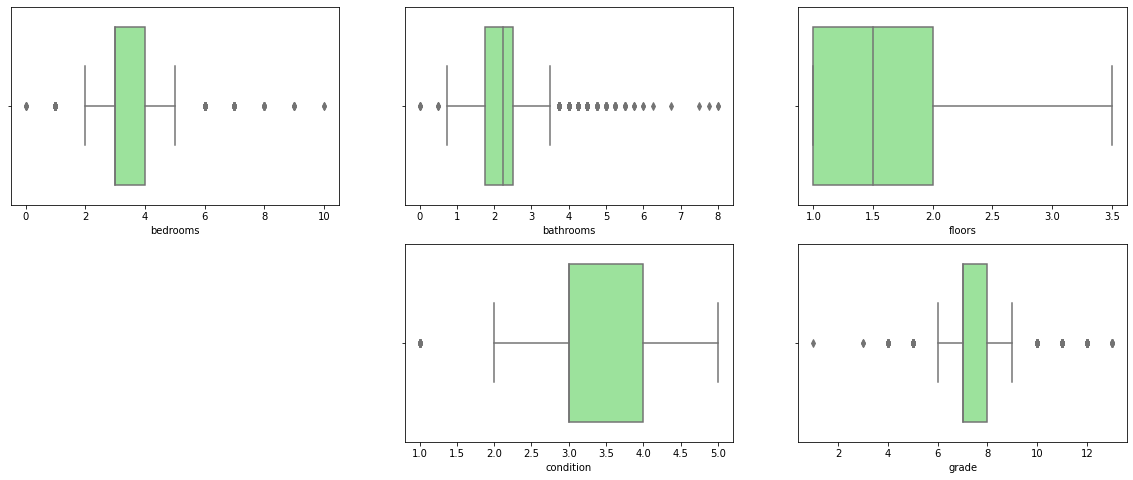

In [12]:
plt.figure(figsize=(20,8))

plt.subplot(231)
sns.boxplot(x=data.bedrooms, color='lightgreen')

plt.subplot(232)
sns.boxplot(x=data.bathrooms, color='lightgreen')

plt.subplot(233)
sns.boxplot(x=data.floors, color='lightgreen')

plt.subplot(235)
sns.boxplot(x=data.condition, color='lightgreen')

plt.subplot(236)
sns.boxplot(x=data.grade, color='lightgreen')

In [13]:
data.loc[data['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [14]:
data = data.loc[data['id']!=8912]

In [15]:
data.loc[(data['price']>12) & (data['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [16]:
data.loc[(data['price']>14) & (data['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
306,306,20150225T000000,14.077876,3,2.00,2350,15021,1.0,0,0,...,8,1770,580,1976,0,98004,47.6408,-122.219,3530,15715
359,359,20150210T000000,14.062371,5,2.50,3400,9500,2.0,0,1,...,8,3400,0,1977,0,98027,47.5645,-122.082,3080,11081
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
1142,1142,20141022T000000,14.133965,3,1.50,1850,10572,1.0,0,0,...,8,1850,0,1953,0,98004,47.6194,-122.208,3030,12752
1542,1542,20141027T000000,14.346139,5,2.00,2500,15250,2.0,1,4,...,8,2500,0,1942,0,98008,47.5883,-122.111,1880,18782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12745,12745,20150223T000000,14.050583,3,1.75,2240,5657,1.5,0,2,...,8,1910,330,1941,0,98105,47.6621,-122.270,2970,5657
12933,12933,20141208T000000,14.089348,4,3.00,2860,10292,1.0,0,0,...,8,2860,0,1953,1999,98004,47.6286,-122.206,1840,10273
13113,13113,20150323T000000,14.077021,5,2.25,2690,10800,1.0,0,3,...,8,2020,670,1956,0,98040,47.5821,-122.247,3380,9134
13145,13145,20150408T000000,14.151984,3,2.75,3130,19530,1.0,1,4,...,8,1690,1440,1947,1984,98008,47.5895,-122.111,2980,18782


In [17]:
data.loc[(data['price']>15) & (data['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1499,1499,20141114T000000,15.163584,4,4.25,5770,21300,2.0,1,4,...,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
2775,2775,20140611T000000,15.770310,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4598,4598,20150421T000000,15.110238,6,4.75,5480,19401,1.5,1,4,...,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
7297,7297,20150508T000000,15.039286,4,4.00,4260,11765,2.0,0,0,...,11,3280,980,1939,2010,98112,47.6380,-122.288,4260,10408
9814,9814,20140904T000000,15.009433,5,4.75,6200,13873,2.0,1,4,...,11,4440,1760,1989,0,98008,47.6050,-122.112,2940,13525
10645,10645,20140911T000000,15.107742,4,3.25,4830,22257,2.0,1,4,...,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
12646,12646,20141230T000000,15.009433,3,3.25,4220,41300,1.0,1,4,...,11,2460,1760,1958,1987,98008,47.6083,-122.110,3810,30401
14231,14231,20150402T000000,15.022978,5,3.75,5350,15360,1.0,0,1,...,11,3040,2310,2008,0,98004,47.6480,-122.218,3740,15940


In [18]:
data = data.loc[data['id']!=456]
data = data.loc[data['id']!=2302]
data = data.loc[data['id']!=4123]
data = data.loc[data['id']!=7259]
data = data.loc[data['id']!=2777]

## Checking Missing Data

<AxesSubplot:>

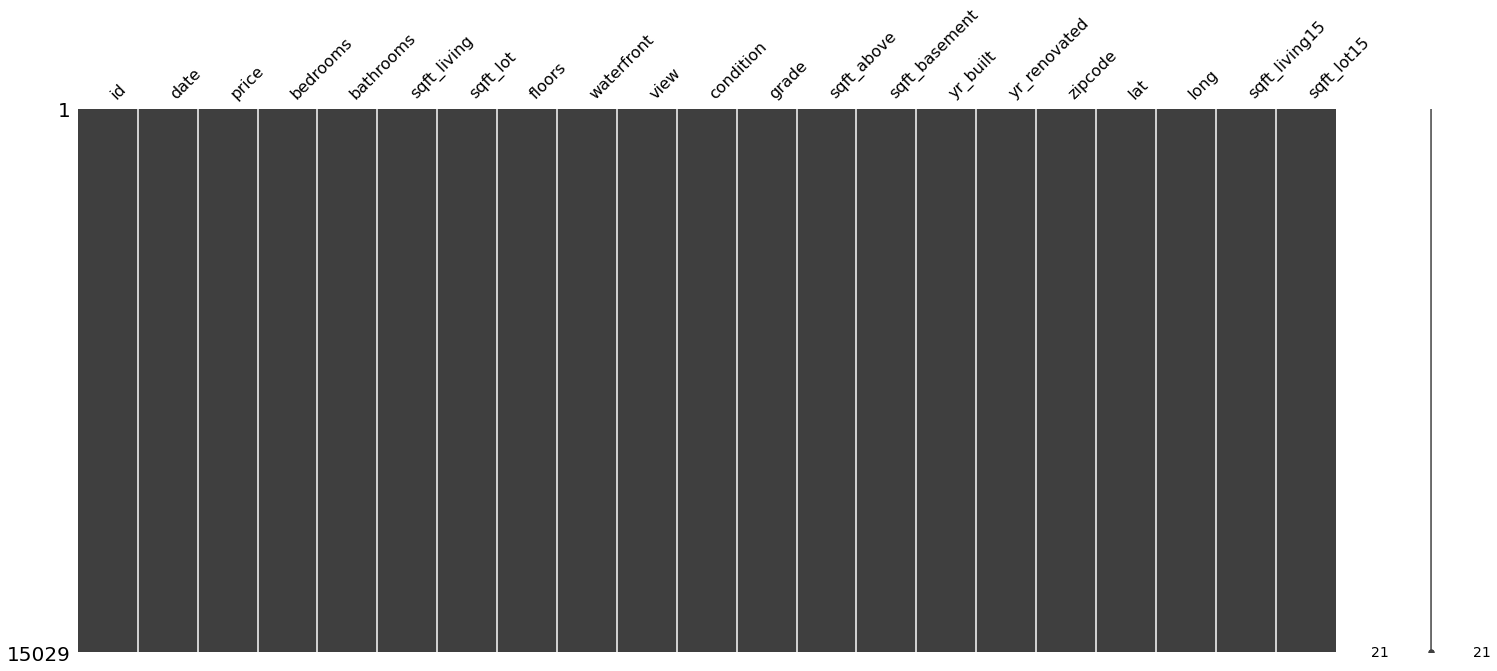

In [19]:
msno.matrix(data)

## Normalization

In [20]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    sub[c] = np.log1p(sub[c].values)

In [21]:
for df in [data,sub]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

## Making Variables

In [22]:
for df in [data,sub]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [23]:
data['per_price'] = data['price']/data['sqft_total_size']
zipcode_price = data.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()

data = pd.merge(data,zipcode_price,how='left',on='zipcode')
sub = pd.merge(sub,zipcode_price,how='left',on='zipcode')

for df in [data,sub]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

del data['per_price']

In [24]:
# target data 분리

y = data['price']
del data['price']

In [25]:
# id feature 제거

del data['id']
del sub['id']
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')


# Data Modeling

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
random_state=41        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [27]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [28]:
def get_scores(models, data, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
      
        X_train, X_test, y_train, y_test = train_test_split(data, y, 
                                                            random_state=random_state,
                                                            test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
       
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        return score_df

get_scores(models, data, y)

,RMSE
GradientBoostingRegressor,139168.130733


In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
# 코드 입력
def my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5):
  # 모델 초기화
    grid_model = GridSearchCV(model, param_grid= param_grid, 
                              scoring= 'neg_mean_squared_error',
                              cv=5,
                              verbose = verbose,
                              n_jobs= n_jobs)
  
  # fitting
    grid_model.fit(data, y)
  
  # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
  
  #데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
  
  # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values('RMSLE')
  
    return results

In [31]:
# 코드 작성
def save_submission(model, data, y, test, model_name, rmsle=None):
    model.fit(data, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME') +  '/project/AIFFEL/E09_Kaggle_2019kaKrHousing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path ='{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [32]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027200,0.164924
2,10,50,-0.029333,0.171270
1,1,100,-0.054870,0.234244
0,1,50,-0.073298,0.270736
